In [3]:
# Compute and get alpha map
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2
import numpy as np
import xml.dom.minidom as md

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import mean_squared_error as mse
from PIL import Image

output_folder = 'images'
ref_output_folder = 'images/references'
mitsuba_binary = './../build/mitsuba'
os.makedirs(ref_output_folder, exist_ok=True)

In [44]:
def convert_img(im):
    im_gamma_correct = np.clip(np.power(im, 0.45), 0, 1)
    im_fixed = Image.fromarray(np.uint8(im_gamma_correct*255))
    
    return np.array(im_fixed)

def update_mis_scene(scene_path, mis_method):
    file = md.parse(scene_path) 
    scene = file.getElementsByTagName("scene")
    defaults = scene[0].getElementsByTagName("default")

    mis_param = [ param for param in defaults if param.attributes['name'].value == 'mis' ][0]
    mis_param.setAttribute('value', mis_method)

    with open(scene_path, "w") as xml_file:
        file.writexml(xml_file)
        
def update_spp_scene(scene_path, spp):
    file = md.parse(scene_path) 
    scene = file.getElementsByTagName("scene")
    defaults = scene[0].getElementsByTagName("default")

    spp_param = [ param for param in defaults if param.attributes['name'].value == 'spp' ][0]
    spp_param.setAttribute('value', spp)

    with open(scene_path, "w") as xml_file:
        file.writexml(xml_file)
        
def read_alpha_map(alpha_map_path):
    
    alpha_arr = []
    with open(alpha_map_path, 'r') as f:
        for line in f.readlines():
            pixel_line = line.split(';')
            pixels_channels = [ list(map(float, pixel.split(','))) for pixel in pixel_line ]
            alpha_arr.append(pixels_channels)
    return np.array(alpha_arr)
        
def compute_methods(ref, scene_file, methods):
    
    computed_images = {}
    for mis_method in methods:
        
        _, scene_name = os.path.split(scene_file)
        scene_name = scene_name.replace('.xml', '')

        output_image_path = f"{output_folder}/{scene_name}_{mis_method}.exr"

        # update scene params
        update_mis_scene(scene_file, mis_method)
    
        # render and load image
        os.system(f'{mitsuba_binary} -t 8 -o {output_image_path} {scene_file}')
        
        image = np.array(cv2.imread(output_image_path))
        image = convert_img(image)
        
        # read alpha map now
        alpha_map_path = output_image_path.replace('.exr', '.map')
        image_map = read_alpha_map(alpha_map_path)

        if mis_method not in computed_images:
            # tuple with image and alpha map
            computed_images[mis_method] = (image, image_map)
            
        print(f'{mis_method}: [MSE: {mse(ref, image)}, SSIM: {ssim(ref, image, channel_axis=2)}]')

Text(0.5, 1.0, 'Power')

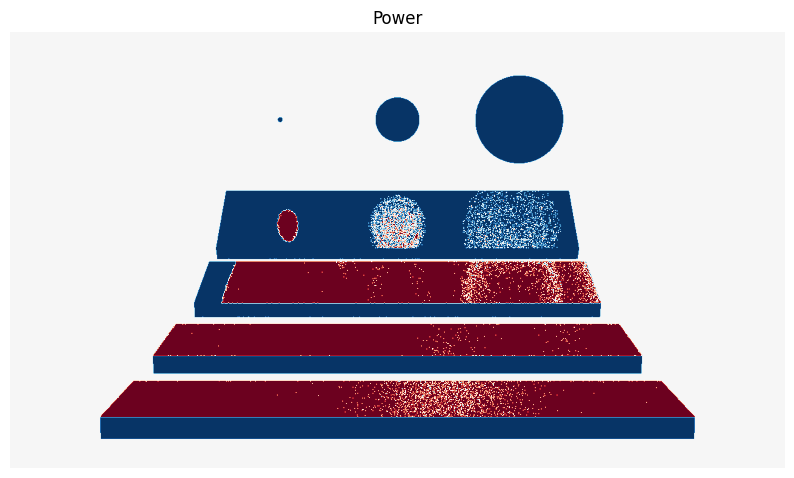

In [54]:
alpha_map = read_alpha_map('images/scene_no_background_linear2.map')
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,1,1).imshow(alpha_map[:,:,0], cmap='RdBu', clim=(0, 1)) 
plt.axis('off'); plt.title('Power')
#fig.add_subplot(1,2,2).imshow(tsallis); plt.axis('off'); plt.title('Tsallis')
#print(f'[NRMSE: {nrmse(ref, tsallis)}, SSIM: {ssim(ref, tsallis, channel_axis=2, data_range=1)}]')

In [37]:
methods = ["balance", "power", "tsallis", "linear1", "linear2", "linear3"]

In [21]:
ref_image_path = os.path.join(ref_output_folder, 'veach_power.exr')
scene_file = "scenes/veach-mis/scene.xml"
update_spp_scene(scene_file, '1000')
if not os.path.exists(ref_image_path):
    os.system(f'{mitsuba_binary} -t 8 -o {ref_image_path} {scene_file}')

In [47]:
image = np.array(cv2.imread(ref_image_path))
ref = convert_img(image)
# reset spp
update_spp_scene(scene_file, "100")
method_images = compute_methods(ref, "scenes/veach-mis/scene_no_background.xml", methods)

2023-03-15 15:54:15 INFO  main  [mitsuba.cpp:335] Mitsuba version 3.2.1 (develop[ac088c3b], Linux, 64bit, 8 threads, 8-wide SIMD)
2023-03-15 15:54:15 INFO  main  [mitsuba.cpp:336] Copyright 2022, Realistic Graphics Lab, EPFL
2023-03-15 15:54:15 INFO  main  [mitsuba.cpp:337] Enabled processor features: avx2 avx fma f16c sse4.2 x86_64
2023-03-15 15:54:15 INFO  main  [xml.cpp:1433] Loading XML file "scenes/veach-mis/scene_no_background.xml" with variant "scalar_rgb"..
2023-03-15 15:54:15 INFO  main  [Scene] Embree ready. (took 0ms)
2023-03-15 15:54:15 INFO  main  [xml.cpp:1450] Done loading XML file "scenes/veach-mis/scene_no_background.xml" (took 801ms).
2023-03-15 15:54:15 INFO  main  [SamplingIntegrator] Starting render job (1280x720, 20 samples, 8 threads)
Rendering [=============================================] (1.71s, ETA: 0ms)     
2023-03-15 15:54:17 INFO  main  [SamplingIntegrator] Rendering finished. (took 1.713s)
2023-03-15 15:54:17 INFO  main  [HDRFilm] ✔  Developing "images/